In [4]:
import torch

In [5]:
model = torch.hub.load('facebookresearch/deit:main',
'deit_tiny_patch16_224', pretrained=True)

Using cache found in /Users/aroibu_admin/.cache/torch/hub/facebookresearch_deit_main


In [6]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [7]:
from torchvision import transforms

In [8]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [9]:
image_path = 'both.png'

In [10]:
from PIL import Image
import numpy as np

In [11]:
img = Image.open(image_path)

In [12]:
img = img.resize((224, 224))

In [13]:
input_tensor = transform(img).unsqueeze(0)

In [14]:
# attention_rollout = VITAttentionRollout(model, head_fusion=args.head_fusion, 
#             discard_ratio=args.discard_ratio)
#         mask = attention_rollout(input_tensor)
#         name = "attention_rollout_{:.3f}_{}.png".format(args.discard_ratio, args.head_fusion)

In [15]:
discard_ratio = 0.9

In [16]:
attention_layer_name='attn_drop'

In [174]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            
            print(attention.shape)
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
                
            # print(attention_heads_fused.shape)

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)


In [175]:
head_fusion='max'

In [176]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

Doing Attention Rollout
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])


In [177]:
mask.shape

(14, 14)

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

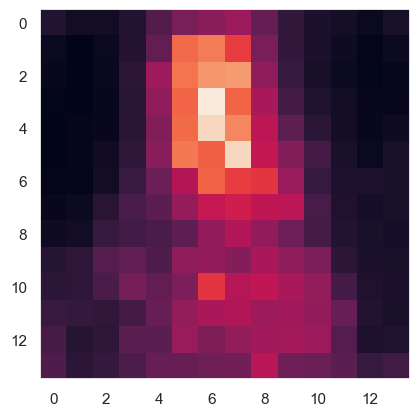

In [180]:
plt.imshow(mask)
plt.grid()

In [181]:
import cv2

In [182]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [183]:
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imshow("Input Image", np_img)
cv2.imshow(name, mask)
# cv2.imwrite("input.png", np_img)
# cv2.imwrite(name, mask)
# cv2.waitKey(-1)

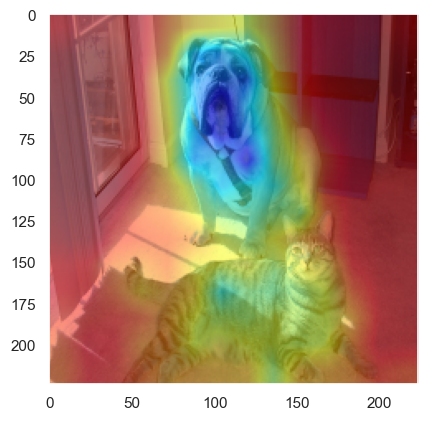

In [184]:
plt.imshow(mask)
plt.grid()

In [206]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    
    results = []
    results2 = []
    results3 = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            results3.append(a)
            result = torch.matmul(a, result)
            results2.append(result)
    
    # # Look at the total attention between the class token,
    # # and the image patches
    # mask = result[0, 0 , 1 :]
    # # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    # mask = mask.reshape(width, width).numpy()
    # mask = mask / np.max(mask)
    # return mask   

    return results, results2, results3

In [207]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [208]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask, mask2, mask3 = attention_rollout(input_tensor)

Doing Attention Rollout
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])
torch.Size([1, 3, 197, 197])


In [209]:
m1 = mask[-1]

In [210]:
print(m1.shape, m1.min(), m1.max(), m1.mean())

torch.Size([1, 3, 197, 197]) tensor(3.3152e-06) tensor(0.2980) tensor(0.0051)


In [211]:
m1.max(axis=1)[0].shape

torch.Size([1, 197, 197])

In [212]:
# attention_heads_fused = attention.max(axis=1)[0]
# m1 = np.array(m1)

In [213]:
m1_fused = m1.max(axis=1)[0]

In [214]:
m1_fused.shape

torch.Size([1, 197, 197])

In [215]:
# flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
# _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
# indices = indices[indices != 0]
# flat[0, indices] = 0

In [216]:
m1_fused.size(0)

1

In [217]:
m1_flat = m1_fused.view(m1_fused.size(0), -1)

In [218]:
m1_flat

tensor([[0.1277, 0.0015, 0.0090,  ..., 0.0071, 0.0033, 0.0010]])

In [219]:
m1_flat.shape

torch.Size([1, 38809])

In [220]:
# _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)

In [221]:
int(m1_flat.size(-1)*discard_ratio)

34928

In [222]:
type(m1_flat)

torch.Tensor

In [223]:
_, indices = m1_flat.topk(int(m1_flat.size(-1)*discard_ratio), -1, False)

In [224]:
indices.shape

torch.Size([1, 34928])

In [225]:
indices = indices[indices != 0]

In [226]:
indices.shape

torch.Size([34928])

In [227]:
m1_flat[0, indices] = 0

In [228]:
m1_flat.shape

torch.Size([1, 38809])

In [229]:
I = torch.eye(m1.size(-1))
a = (m1 + 1.0*I)/2
a = a / a.sum(dim=-1)

RuntimeError: The size of tensor a (197) must match the size of tensor b (3) at non-singleton dimension 2

In [230]:
I.shape

torch.Size([197, 197])

In [231]:
a.shape

torch.Size([1, 3, 197, 197])

In [232]:
a.sum(dim=-1).shape

torch.Size([1, 3, 197])

In [233]:
len(mask2)

12

In [234]:
m1 = mask2[-2]

In [235]:
m1.shape

torch.Size([1, 197, 197])

In [236]:
#     # Look at the total attention between the class token,
#     # and the image patches
#     mask = result[0, 0 , 1 :]
#     # In case of 224x224 image, this brings us from 196 to 14
#     width = int(mask.size(-1)**0.5)
#     mask = mask.reshape(width, width).numpy()
#     mask = mask / np.max(mask)
#     return mask   

In [237]:
msk = m1[0,0,1:]

In [238]:
msk.shape

torch.Size([196])

In [239]:
width = int(msk.size(-1)**0.5)
width

14

In [240]:
msk = msk.reshape(width, width)

In [241]:
msk.shape

torch.Size([14, 14])

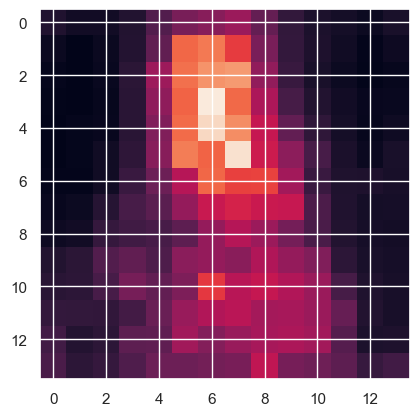

In [242]:
plt.imshow(msk)

In [252]:

for idx in range(len(mask3)):
    m1 = mask3[idx]
    print(m1.shape)
    msk = m1[0,0,1:]
    print(msk.shape)
    width = int(msk.size(-1)**0.5)
    msk = msk.reshape(width, width)
    # plt.figure()
    # plt.imshow(msk)
    # plt.grid()

torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])
torch.Size([1, 197, 197])
torch.Size([196])


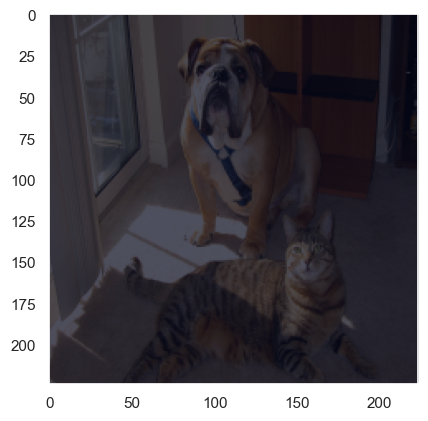

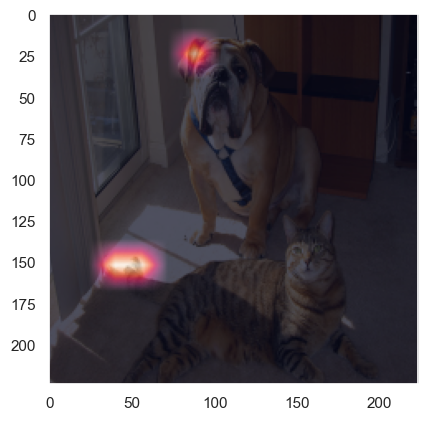

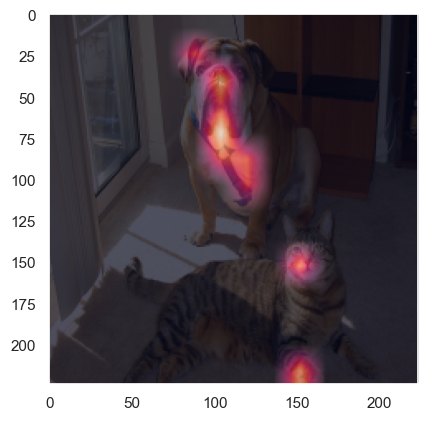

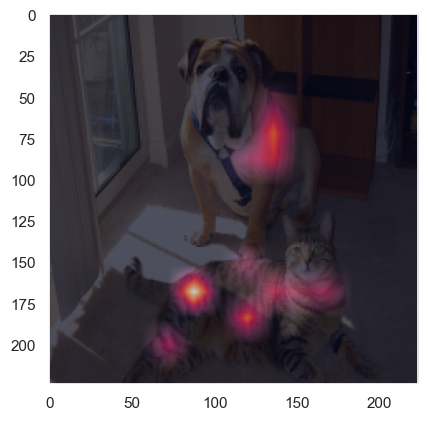

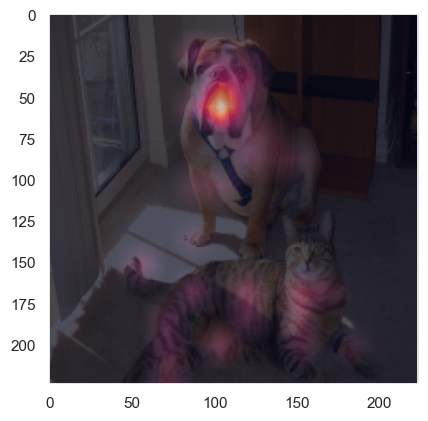

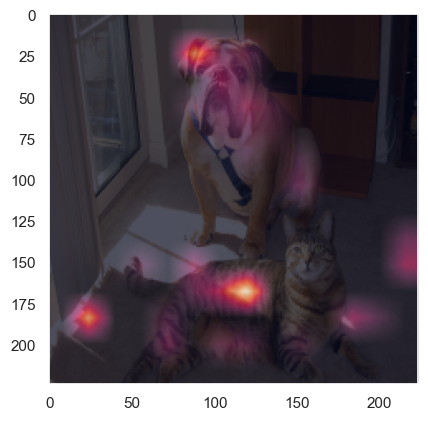

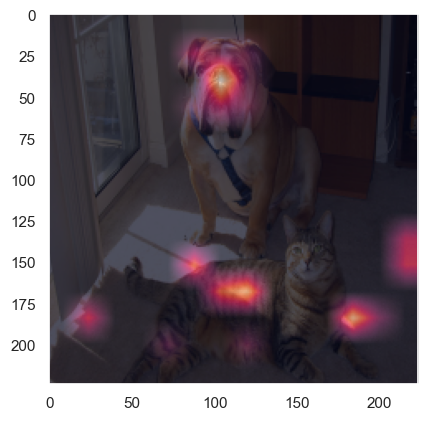

In [244]:

for idx in range(5,len(mask3)):
    m1 = mask3[idx]
    msk = m1[0,0,1:]
    width = int(msk.size(-1)**0.5)
    msk = msk.reshape(width, width).numpy()
    
    np_img = np.array(img)[:, :, ::-1]
    msk = cv2.resize(msk, (np_img.shape[1], np_img.shape[0]))
    # msk = show_mask_on_image(np_img, msk)
     
    plt.figure()
    plt.imshow(img)
    plt.imshow(msk, alpha=0.7)
    plt.grid()





In [247]:
x = mask[-1]
xfused = x.max(axis=1)[0]

xflat = xfused.view(xfused.size(0), -1)
_, indices = xflat.topk(int(xflat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
xflat[0, indices] = 0

I = torch.eye(xfused.size(-1))
a = (xfused + 1.0*I)/2
# a = a / a.sum(dim=-1)

In [248]:
a.shape

torch.Size([1, 197, 197])

In [249]:
a.sum(dim=-1).shape

torch.Size([1, 197])

In [250]:
a = a / a.sum(dim=-1)

In [251]:
a.shape

torch.Size([1, 197, 197])